# **Preprocessing Data (NO2 Medan)**
Pada khasus ini data di processing dengan 2 cara menangani data missing value dan membuat data menjadi supervised

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### 1.1 Menangani Missing Value  

Untuk menjaga **kontinuitas data deret waktu (time series)** dan memastikan model prediksi dapat mempelajari pola historis dengan akurat, nilai-nilai **NO₂ yang hilang (missing values)** perlu diisi kembali sebelum digunakan dalam proses pelatihan model.  

Dalam kasus ini, diterapkan **metode interpolasi linier (linear interpolation)** untuk memperkirakan nilai yang hilang berdasarkan hubungan antar data di sekitarnya.  

Metode ini dipilih karena memiliki beberapa keunggulan:  
1. **Mampu memperkirakan nilai kosong** berdasarkan kecenderungan perubahan nilai sebelum dan sesudah tanggal yang hilang.  
2. **Cocok untuk data lingkungan**, seperti konsentrasi gas NO₂, yang umumnya mengalami perubahan secara bertahap dan tidak ekstrem dari hari ke hari.  
3. **Menjaga urutan kronologis data**, karena interpolasi linier tidak mengubah struktur temporal dataset, sehingga pola waktu tetap konsisten.  

Dengan penerapan metode ini, seluruh nilai hilang pada kolom NO₂ dapat diestimasi secara logis tanpa menimbulkan distorsi pada tren data aslinya.  
Dataset hasil interpolasi kemudian siap digunakan pada tahap selanjutnya, yaitu pembentukan data *supervised learning*.

### Contoh Data

In [11]:
new_df = pd.read_csv('timeseries.csv')
new_df = new_df.sort_values(by='date').reset_index(drop=True)
new_df['date'] = pd.to_datetime(new_df['date']).dt.date
new_df

date  feature_index       NO2
0    2020-04-30              0       NaN
1    2020-05-01              0       NaN
2    2020-05-02              0  0.000029
3    2020-05-03              0  0.000025
4    2020-05-04              0       NaN
..          ...            ...       ...
391  2021-05-26              0       NaN
392  2021-05-27              0       NaN
393  2021-05-28              0  0.000028
394  2021-05-29              0  0.000020
395  2021-05-30              0  0.000034

[396 rows x 3 columns]

/tmp/ipython-input-1178675646.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",


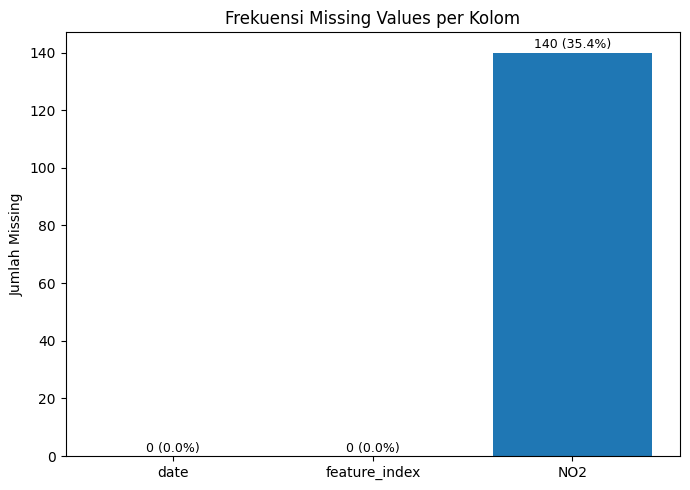

Missing Count  Missing Percent (%)
date                       0                 0.00
feature_index              0                 0.00
NO2                      140                35.35

In [12]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

fig, ax = plt.subplots(figsize=(7,5))

bars = ax.bar(missing_count.index, missing_count)

ax.set_title("Frekuensi Missing Values per Kolom")
ax.set_ylabel("Jumlah Missing")

for i, v in enumerate(missing_count):
    ax.text(i, v + 0.5, f"{v} ({missing_percent[i]:.1f}%)",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

In [13]:
new_df = pd.Series(new_df['NO2'].values, index=new_df['date'], name='NO2')
new_df = new_df.interpolate(method='linear').bfill()
new_df = pd.DataFrame(new_df).reset_index()
new_df.to_csv("timeseries_cleaned.csv")
new_df

date       NO2
0    2020-04-30  0.000029
1    2020-05-01  0.000029
2    2020-05-02  0.000029
3    2020-05-03  0.000025
4    2020-05-04  0.000026
..          ...       ...
391  2021-05-26  0.000033
392  2021-05-27  0.000031
393  2021-05-28  0.000028
394  2021-05-29  0.000020
395  2021-05-30  0.000034

[396 rows x 2 columns]

In [14]:
missing_count = new_df.isnull().sum()
missing_percent = (missing_count / len(new_df)) * 100

missing_table = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

missing_table

Missing Count  Missing Percent (%)
date              0                  0.0
NO2               0                  0.0

Setelah proses **interpolasi linier** dilakukan pada kolom NO₂, hasil pemeriksaan ulang menunjukkan bahwa seluruh nilai yang hilang telah berhasil diisi dengan baik.  
Dengan demikian, dataset kini **bebas dari missing value** dan siap digunakan untuk tahap berikutnya, yaitu **pemodelan prediksi konsentrasi NO₂** menggunakan metode *K-Nearest Neighbors (KNN) Regression*.  

### 2.2 Konversi ke Supervised Learning  


Pada tahap ini, dilakukan proses **konversi data deret waktu (time series)** menjadi bentuk **supervised learning** agar dapat digunakan dalam algoritma pembelajaran mesin.  
Hal ini penting karena:  

- Data *time series* pada dasarnya hanya berisi nilai-nilai berdasarkan urutan waktu.  
- Sementara *supervised learning* membutuhkan pasangan **input (X)** dan **output (y)** untuk melatih model.  

Oleh sebab itu, dilakukan transformasi dengan cara **membuat fitur keterlambatan (lag features)**, yaitu menjadikan nilai-nilai NO₂ beberapa hari sebelumnya sebagai variabel input untuk memprediksi nilai NO₂ hari berikutnya.  

Dalam penelitian ini, dilakukan eksperimen dengan menggunakan **lag 2 hingga 5 hari sebelumnya** sebagai fitur masukan.  

#### Langkah-langkah Konversi:
1. **Menginisialisasi dataset lag 1–5 hari**, yang masing-masing akan digunakan untuk membuat data supervised.  



In [35]:
day1 = new_df
day2 = new_df
day3 = new_df
day4 = new_df
day5 = new_df

2. **Membuat data supervised dengan lag t1 dan t2**, di mana dua hari sebelumnya dijadikan fitur masukan.  


In [40]:
day1 = day1.drop(columns=['date'])
n = 1
for i in range(1, n + 1):
    names = f"t{i}"
    day1[names] = day1['NO2'].shift(i)
day1 = day1.dropna().reset_index(drop=True)
day1.to_csv('day1.csv', index=False)
display(day1.head())

NO2        t1
0  0.000029  0.000029
1  0.000029  0.000029
2  0.000025  0.000029
3  0.000026  0.000025
4  0.000027  0.000026

3. **Membuat data supervised dengan lag t1 dan t2**, di mana dua hari sebelumnya dijadikan fitur masukan.  


In [36]:
day2 = day2.drop(columns=['date'])
n = 2
for i in range(1, n + 1):
    names = f"t{i}"
    day2[names] = day2['NO2'].shift(i)
day2 = day2.dropna().reset_index(drop=True)
day2.to_csv('day2.csv', index=False)
display(day2.head())

NO2        t1        t2
0  0.000029  0.000029  0.000029
1  0.000025  0.000029  0.000029
2  0.000026  0.000025  0.000029
3  0.000027  0.000026  0.000025
4  0.000019  0.000027  0.000026

4. **Membuat data supervised dengan lag t1, t2, dan t3**, untuk melihat pengaruh tambahan satu hari historis.  


In [37]:
day3 = day3.drop(columns=['date'])
n = 3
for i in range(1, n + 1):
    names = f"t{i}"
    day3[names] = day3['NO2'].shift(i)
day3 = day3.dropna().reset_index(drop=True)
day3.to_csv('day3.csv', index=False)
display(day3.head())

NO2        t1        t2        t3
0  0.000025  0.000029  0.000029  0.000029
1  0.000026  0.000025  0.000029  0.000029
2  0.000027  0.000026  0.000025  0.000029
3  0.000019  0.000027  0.000026  0.000025
4  0.000029  0.000019  0.000027  0.000026

5. **Membuat data supervised dengan lag t1, t2, t3, dan t4**, untuk memperluas konteks waktu.  


In [38]:
day4 = day4.drop(columns=['date'])
n = 4
for i in range(1, n + 1):
    names = f"t{i}"
    day4[names] = day4['NO2'].shift(i)
day4 = day4.dropna().reset_index(drop=True)
day4.to_csv('day4.csv', index=False)
display(day4.head())

NO2        t1        t2        t3        t4
0  0.000026  0.000025  0.000029  0.000029  0.000029
1  0.000027  0.000026  0.000025  0.000029  0.000029
2  0.000019  0.000027  0.000026  0.000025  0.000029
3  0.000029  0.000019  0.000027  0.000026  0.000025
4  0.000016  0.000029  0.000019  0.000027  0.000026

6. **Membuat data supervised dengan lag t1, t2, t3, t4, dan t5**, agar model dapat mempertimbangkan kondisi lima hari sebelumnya sebagai prediktor nilai NO₂ hari ini.  



In [39]:
day5 = day5.drop(columns=['date'])
n = 5
for i in range(1, n + 1):
    names = f"t{i}"
    day5[names] = day5['NO2'].shift(i)
day5 = day5.dropna().reset_index(drop=True)
day5.to_csv('day5.csv', index=False)
display(day5.head())

NO2        t1        t2        t3        t4        t5
0  0.000027  0.000026  0.000025  0.000029  0.000029  0.000029
1  0.000019  0.000027  0.000026  0.000025  0.000029  0.000029
2  0.000029  0.000019  0.000027  0.000026  0.000025  0.000029
3  0.000016  0.000029  0.000019  0.000027  0.000026  0.000025
4  0.000019  0.000016  0.000029  0.000019  0.000027  0.000026

Hasil dari proses ini berupa beberapa versi dataset *supervised*, masing-masing dengan kombinasi jumlah *lag features* yang berbeda.  
Dataset inilah yang selanjutnya digunakan untuk pelatihan model prediksi kualitas udara.